# Convert OpenSN data to name,host,type,x,y,z,t,lum

Data downloaded from The Open Supernova Catalog https://sne.space on Aug. 20, 2019

In [5]:
import pandas as pd
import numpy as np
from astropy import units
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import WMAP9
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv('OpenSNCat.csv')
#select the ones that have all the data we need
df = df.loc[(df['R.A.'].notnull()) & \
              (df['Dec.'].notnull()) & \
              (df['Disc. Date'].notnull())]# & \
              #(df['dL (Mpc)'].notnull()) & \
              #(df['Mmax'].notnull())]


I will have to iterate through the rows, since some coords have multiple entries, and some dates are bad

In [7]:
#get the mean distance, so that I can use that for sources w/o distances
mDist = df['dL (Mpc)'].mean()
mMmax = df['Mmax'].mean()
print("mean distance", mDist)
print('max distance', df['dL (Mpc)'].max())
print("mean Mmax", mMmax)

mean distance 1077.1528440219008
max distance 98900.0
mean Mmax -18.362331456582606


In [9]:
x = []
y = []
z = []
t = []

log10lum = []
name = []
host = []
tpe = []
dflag = []

#for datetime
fmt = '%Y/%m/%d'

N = 1e10
for index, row in df.iterrows():
    bad = False
    
    #there are still some dates that cause errors (e.g., 185/12/07/)
    date = str(row['Disc. Date'])
    pos = date.find(',')
    fmt0 = fmt
    if (pos != -1):    
        date = row['Disc. Date'][0:pos]
    pos1 = date.find('/')
    pos2 = date.rfind('/')
    if (pos1 == -1):
        fmt0 = '%Y'
    if (pos1 != -1 and pos2 == pos1):
        fmt0 = '%Y/%m'
    if (pos1 != -1 and pos2 != pos1 and pos2 == len(date)):
        fmt0 = '%Y/%m/'
    if (fmt0 == fmt):
        val1 = int(date[0:pos1])
        if (val1 <= 12):
            fmt0 = '%m/%d/%Y'
        if (val1 > 12 and val1 < 1800):
            bad = True

    if (not bad):
        dt = datetime.datetime.strptime(date, fmt0) 
        t.append(dt.year + dt.month/12. + dt.day/365.24)
        
        ra = row['R.A.']
        pos = str(ra).find(',')
        if (pos != -1):    
            ra = row['R.A.'][0:pos]

        dec = row['Dec.']
        pos = str(dec).find(',')
        if (pos != -1):    
            dec = row['Dec.'][0:pos]

        if (pd.isna(row['dL (Mpc)'])):
            d = mDist*units.Mpc
            dflag.append(-1)
        else:
            d = row['dL (Mpc)']*units.Mpc
            dflag.append(1)
        #convert to comoving distance
        cosmoz = Distance(d).z
        
        
        c1 = SkyCoord(ra, dec, unit=(units.hourangle, units.deg), distance=WMAP9.comoving_distance(cosmoz)).galactic.cartesian
        x.append(c1.x.to(units.Mpc).value)
        y.append(c1.y.to(units.Mpc).value)
        z.append(c1.z.to(units.Mpc).value)

        m = mMmax
        if (pd.notna(row['Mmax'])):
            m = row['Mmax']
        log10lum.append(0.4*(4.74 - m))

        name.append(row['Name'])
        host.append(row['Host Name'])
        tpe.append(row['Type'])
        
    if (index > N):
        break
    

In [11]:
d = np.sqrt(np.array(x)**2. + np.array(y)**2. + np.array(z)**2.)
print(max(d))

9547.875039034454


1868.0860712590807 2019.680356295404


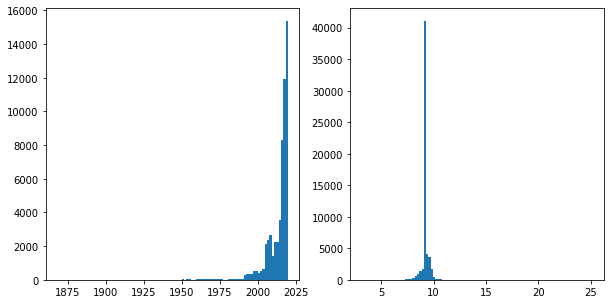

In [12]:
print(min(t), max(t))
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
_ = ax1.hist(t,bins=100)
_ = ax2.hist(log10lum,bins=100)

### Convert the types to a float between 0 and 1 for possible colormap

['nan' 'I Pec' 'Impostor-' 'SLSN-R' 'TDE' 'LBV' 'Ia-91bg' 'Ic BL'
 'Ib/Ic (Ca rich)' 'AGN' 'Ia-02ic-like' 'Jovan' 'Other'
 'Ib/Ic (Ca rich?)?' 'LGRB' 'Ia/Ic' 'ulense' 'nIa' 'Dwarf' 'II-p' 'Ia-p'
 'II L' 'IIn' 'I?' 'LBV to IIn' 'Ic/Ic-BL' 'Ia-02cx' 'II L?' 'IIn?'
 'dwarf' 'IIn/Ibn' 'Ib' 'other' 'Ic?' 'Ia?' 'II/IIb' 'Ib (Ca rich)'
 'SLSN?' 'Ia/c' 'I-faint' 'Ia-HV' 'Ib Pec' 'SLSN-II?' 'BL' 'Pec' 'Ia-99aa'
 'I' 'II P?' 'Ib/c-BL' 'II?' 'Lensed SN Ia' 'Candidate' 'Candidate?'
 'SLSN-I?' 'PISN?' 'II P' 'II Pec?' 'Radio' 'Super-Luminous Ic' 'Ib-IIb'
 'Star' 'CC' 'II P Pec' 'II Pec' 'BL-Ic' 'Ic Pec' 'XRB' 'II' 'Ib/c' 'Ia*'
 'CV' 'SLSN-I' 'IIb/Ib' 'SLSN-IIn' 'Comet' 'IIb/Ib/Ic (Ca rich)' 'Ia-91T'
 'Ia CSM' 'CN' 'maser' 'Ic' 'LRV?' 'Ia-pec.' 'Ia' 'IIn/LBV' 'Ia Pec?'
 'Ibn/IIbn' 'Ii' 'Ib-Ca-rich' 'IIb?' 'II-P/L' 'LPV' 'removed' 'IIn-09ip'
 'Variable' 'NT' 'IIn-pec/LBV' 'Ibn' 'II/Ic' 'IIb' 'Ca-rich' 'Ib-Ca' 'DN'
 'LCH' 'SLSN-II' 'II/Ib/c' 'LSQ' 'blue' 'Ic-lum?' 'IIn Pec' 'SLSN-I-R'
 'Ib/Ic' 'Iax[02

/Users/ageller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


ntotal: 56744
nremoved: 139
nIa: 11395


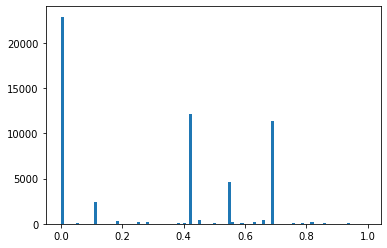

In [13]:
utpe = np.array(list(set(tpe)))
print(utpe)
tp = []
nremoved = 0
nIa = 0
for tt in tpe:
    xx = np.where(utpe == tt)[0]
    if (len(xx) == 0): #nan values
        tp.append(0)
    else:
        tp.append(xx[0]/len(utpe))
        
    if (tt == 'removed'):
        nremoved += 1
    if (tt == 'Ia'):
        nIa += 1

print("ntotal:", len(tp))
print("nremoved:", nremoved)
print("nIa:", nIa)

f, ax = plt.subplots()
_ = ax.hist(tp,bins=100)

### Write this to a "raw" file

In [14]:
import csv
csvfile = open("OpenSNCatConverted.raw", 'wt')
csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)

for i in range(len(x)):
    csvwriter.writerow([x[i], y[i], z[i], 
                        t[i], log10lum[i], tp[i],
                        dflag[i], 2, 3])
csvfile.close()


frac = 0.01
csvfile = open("OpenSNCatConvertedSmall.raw", 'wt')
csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)

for i in range(len(x)):
    xx = np.random.random()
    if (xx <= frac):
        csvwriter.writerow([x[i], y[i], z[i], 
                            t[i], log10lum[i], tp[i],
                            dflag[i], 2, 3])
csvfile.close()

In [15]:
print(log10lum[19])

9.240932582633041


In [16]:
print(pd.isna(df['Mmax'][18]))
print(df['Mmax'][18])
print(mMmax)
print(0.4*(4.74 - mMmax))

False
-18.5
-18.362331456582606
9.240932582633041
